# **Data Exploration and Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import sklearn
import gmaps

In [126]:
#reading datas

customer = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_item = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")
#geo_customer = pd.read_csv("olist_geolocation_customer.csv")
#geo_seller = pd.read_csv("olist_geolocation_seller.csv")
prod_category = pd.read_csv("product_category_name_translation.csv")

In [127]:
#checking number of columns , column names and number of rows

datasets = [customer,geolocation,order_item, payments, order, products,reviews,sellers, prod_category]
titles = ["Customers","Geolocations","Items", "Payments", "Orders", "Products","Reviews","Sellers","Category translation"]

info_df = pd.DataFrame({},)
info_df['Dataset']= titles

info_df['# of Columns']= [len(df.columns) for df in datasets ]
info_df['Column Names']= [', '.join(list(df.columns)) for df in datasets] 
info_df['# of Rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Blues')

,Dataset,# of Columns,Column Names,# of Rows
0,Customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,Geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,Items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,Payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,Orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
5,Products,9,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
6,Reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224
7,Sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095
8,Category translation,2,"product_category_name, product_category_name_english",71


In [128]:
#Checking datatypes
datasets = [customer,geolocation,order_item, payments, order, products,reviews,sellers, prod_category]
titles = ["Customers","Geolocations","Items", "Payments", "Orders", "Products","Reviews","Sellers","Category translation"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
dtype = pd.DataFrame({},)
dtype['Dataset']= titles

dtype['Numeric features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
dtype['Numeric features name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
dtype['Object features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
dtype['Object features name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
dtype['Bool features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
dtype.style.background_gradient(cmap='Blues')

,Dataset,Numeric features,Numeric features name,Object features,Object features name,Bool features
0,Customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,Geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,Items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,Payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,Orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
5,Products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2,"product_id, product_category_name",0
6,Reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
7,Sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0
8,Category translation,0,,2,"product_category_name, product_category_name_english",0


# **Data Exploration**

**Customer Data**

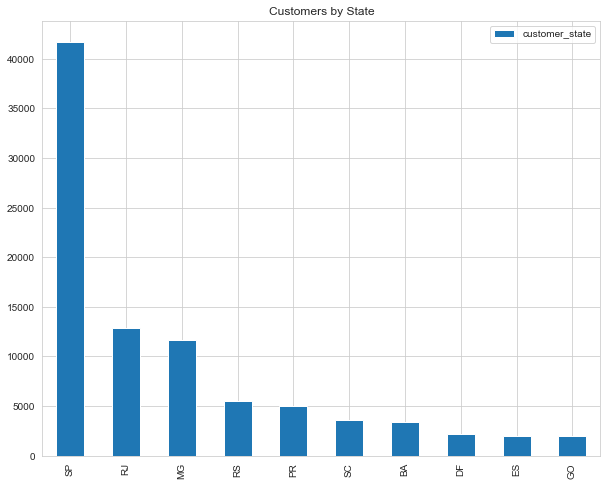

In [129]:
customer.customer_state.value_counts()[:10].plot(kind='bar',figsize=(10,8))
plt.legend()
plt.title('Customers by State')
plt.show()

In [130]:
#Top 10 cities bassed on orders
customer.customer_city.value_counts().sort_values(ascending=False)[:10]

sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: customer_city, dtype: int64

**Sellers and unique products**

In [131]:
print('Number of sellers :',order_item.seller_id.unique().shape[0])
print('Number of unique products :',order_item.product_id.unique().shape[0])

Number of sellers : 3095
Number of unique products : 32951


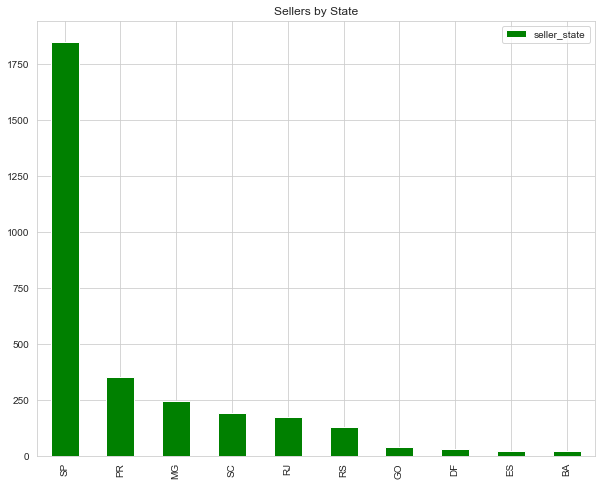

In [132]:
#top 10 seller state
sellers.seller_state.value_counts().sort_values(ascending=False)[:10].plot(kind='bar',color='g',figsize=(10,8))
plt.legend()
plt.title('Sellers by State')
plt.show()

**Price and Payment features**

In [133]:
order_item.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

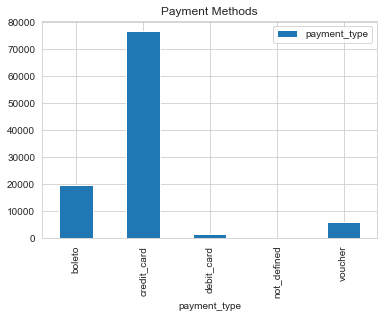

In [134]:
#Most used Payment method for orders
payments['payment_type'].groupby(payments['payment_type']).count().plot(kind='bar')
plt.legend(loc = 'upper right')
plt.title('Payment Methods')
plt.show()

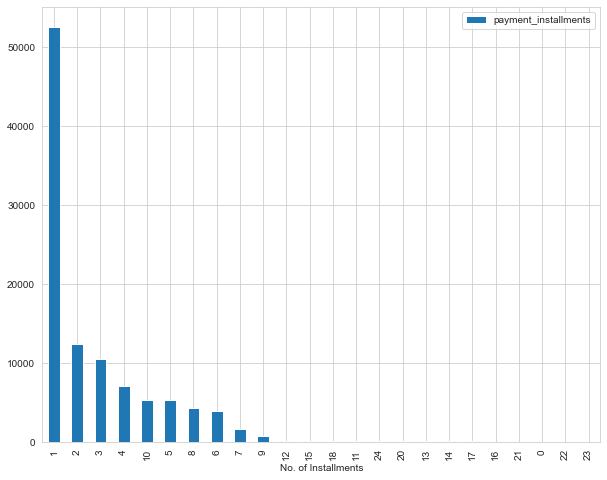

In [135]:
#number of installments feature
payments.payment_installments.value_counts().plot(kind = 'bar',figsize=(10,8))
plt.legend()
plt.xlabel('No. of Installments')
plt.show()

**Product Review**

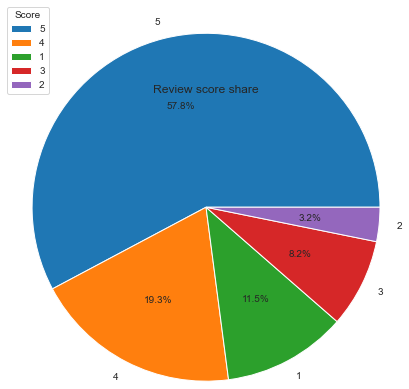

In [136]:
#pie chart for review_score
reviews.review_score.value_counts().plot(kind = 'pie',radius=2,autopct='%.1f%%')
plt.legend(loc= 'lower right', bbox_to_anchor = (-0.2,1), title = 'Score')
plt.title('Review score share', loc = 'center' )
plt.show()

In [137]:
#order_status
pd.DataFrame(order.order_status.value_counts()/len(order)*100)

,order_status
delivered,97.020344
shipped,1.113223
canceled,0.628513
unavailable,0.612423
invoiced,0.315765
processing,0.302692
created,0.005028
approved,0.002011


**Products Data**

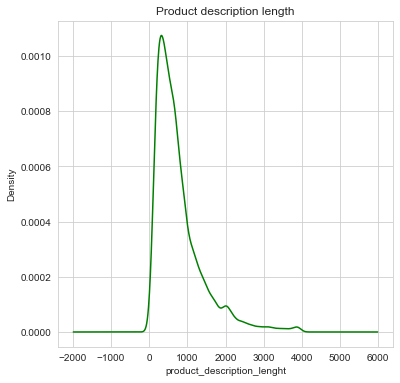

In [138]:
#Density plot of product_description_length and 
products.product_description_lenght.plot(kind='density',figsize=(6,6),color= 'g')
plt.xlabel('product_description_lenght')
plt.title('Product description length')
plt.show()

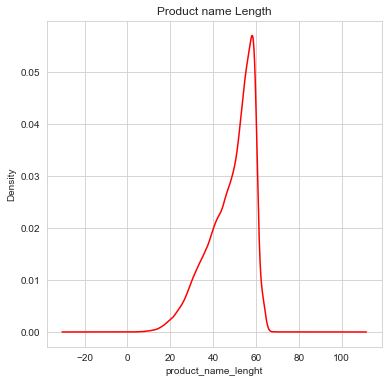

In [139]:
products.product_name_lenght.plot(kind='density',figsize=(6,6),color= 'r')
plt.xlabel('product_name_lenght')
plt.title('Product name Length')
plt.show()

# **Feature Engineering**

Keeping only the unique zip code prefix to form a key to join tables

In [140]:
geo.shape

(1000163, 5)

In [141]:
geo.drop_duplicates(subset='geolocation_zip_code_prefix',inplace=True)

In [142]:
geo.shape

(19015, 5)

In [143]:
customer.rename(columns={'customer_zip_code_prefix':'zip_code_prefix'},inplace=True)
sellers.rename(columns={'seller_zip_code_prefix':'zip_code_prefix'},inplace=True)

In [144]:
geo.rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix'},inplace=True)

Merging customer based datasets

In [145]:
data_customer = pd.merge(order,reviews,on='order_id')
data_customer = pd.merge(data_customer,payments,on='order_id')
data_customer = pd.merge(data_customer,customer,on='customer_id')

In [146]:
#peforming left outer join as we need every geo based address related to customer
data_customer = pd.merge(data_customer,geo,how='left',on='zip_code_prefix')
data_customer.shape

(103677, 26)

Merging seller based datasets

In [147]:
data_seller = pd.merge(order_item,products,on='product_id')
data_seller = pd.merge(data_seller,sellers,on='seller_id')
data_seller = pd.merge(data_seller,prod_category,on='product_category_name')

In [148]:
#peforming left outer join as we need every geo based address related to seller
data_seller = pd.merge(data_seller,geo,how='left',on='zip_code_prefix')
data_seller.shape

(111023, 23)

In [149]:
data = pd.merge(data_customer,data_seller,on='order_id')
data.shape

(115609, 48)

In [150]:
data.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             101808
review_comment_message            66703
review_creation_date                  0
review_answer_timestamp               0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
customer_unique_id                    0
zip_code_prefix_x                     0
customer_city                         0
customer_state                        0
geolocation_lat_x                   310
geolocation_lng_x                   310
geolocation_city_x                  310


In [151]:
data = data[data['order_status'] == 'delivered']

Dropping unwanted columns due to large missing values and irrelevancy

In [152]:
data = data.drop(['review_comment_title','review_comment_message','order_id','customer_id',
                  'geolocation_state_y','geolocation_city_y','geolocation_city_x',
                  'geolocation_state_x','product_category_name','order_id','customer_id',
                  'review_id','order_status','order_approved_at'], axis = 1)

Removing Null Values

In [153]:
data.dropna(how='any',inplace=True)

In [154]:
data.shape

(112644, 36)

In [155]:
data.rename(columns = {'product_category_name_english':'product_category_name',
                       'zip_code_prefix_x':'zipCode_customer',
                       'zip_code_prefix_y':'zipCode_seller'},inplace=True)

In [156]:
data.head()

,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,zipCode_seller,seller_city,seller_state,product_category_name,geolocation_lat_y,geolocation_lng_y
0,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4,2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,...,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,-23.680114,-46.452454
1,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4,2017-10-11 00:00:00,2017-10-12 03:43:48,3,voucher,1,...,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,-23.680114,-46.452454
2,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4,2017-10-11 00:00:00,2017-10-12 03:43:48,2,voucher,1,...,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,-23.680114,-46.452454
3,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,4,2018-08-08 00:00:00,2018-08-08 18:37:50,1,boleto,1,...,400.0,19.0,13.0,19.0,31570,belo horizonte,SP,perfumery,-19.810119,-43.984727
4,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5,2018-08-18 00:00:00,2018-08-22 19:07:58,1,credit_card,3,...,420.0,24.0,19.0,21.0,14840,guariba,SP,auto,-21.362358,-48.232976


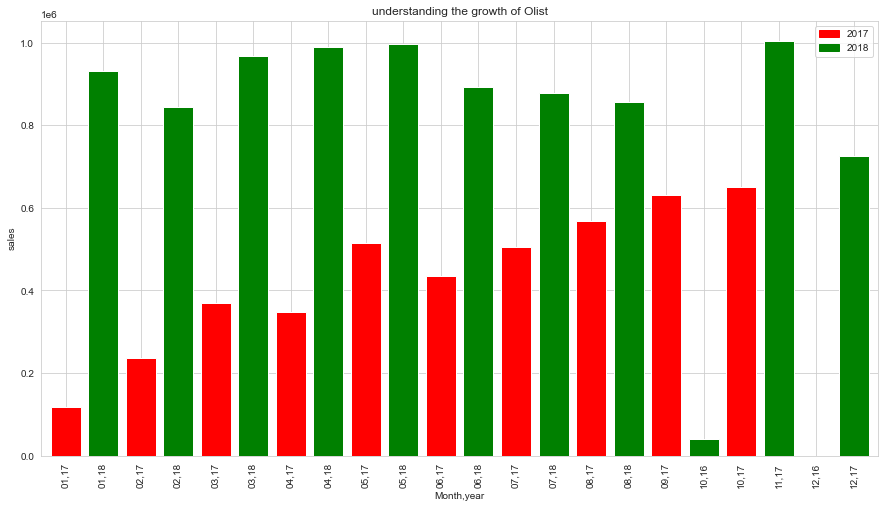

In [157]:
#understanding the growth of Olist 
import matplotlib.patches as mpatches
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
monthly_sales_data = data.groupby(data['order_purchase_timestamp'].dt.strftime('%m,%y'))['price'].sum().plot(kind='bar',figsize = (15,8),color=['r','g'],width=0.8)
plt.ylabel('sales')

red_patch = mpatches.Patch(color='red', label='2017')
green_patch = mpatches.Patch(color='green', label='2018')
plt.legend(handles=[red_patch,green_patch])
plt.xlabel('Month,year')
plt.title('understanding the growth of Olist')
plt.show()

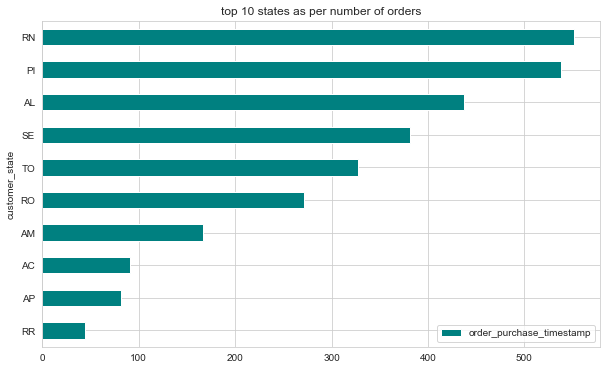

In [158]:
#top 10 states as per number of orders
data.groupby(data['customer_state'])['order_purchase_timestamp'].count().sort_values()[:10].plot(kind='barh',figsize=(10,6),color='teal')
plt.legend()
plt.title('top 10 states as per number of orders')
plt.show()

In [159]:
print('Total unique category are ',data.product_category_name.unique().shape[0])

Total unique category are  71


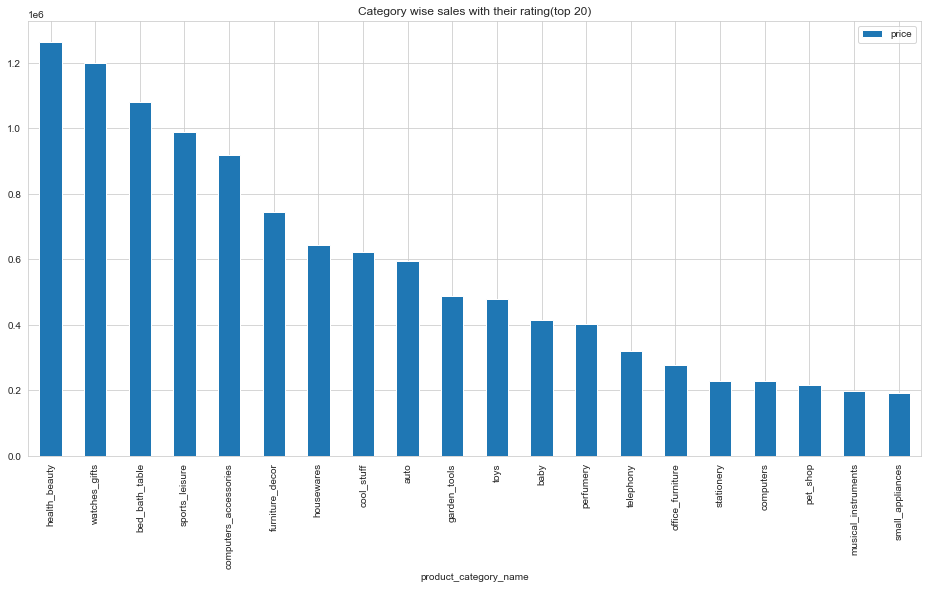

In [160]:
#category wise sales with their rating(top 20)
data.groupby(data['product_category_name'])['price'].sum().sort_values(ascending=False)[:20].plot(kind='bar',figsize=(16,8))
plt.legend()
plt.title('Category wise sales with their rating(top 20)')
plt.show()

In [161]:
import seaborn as sns

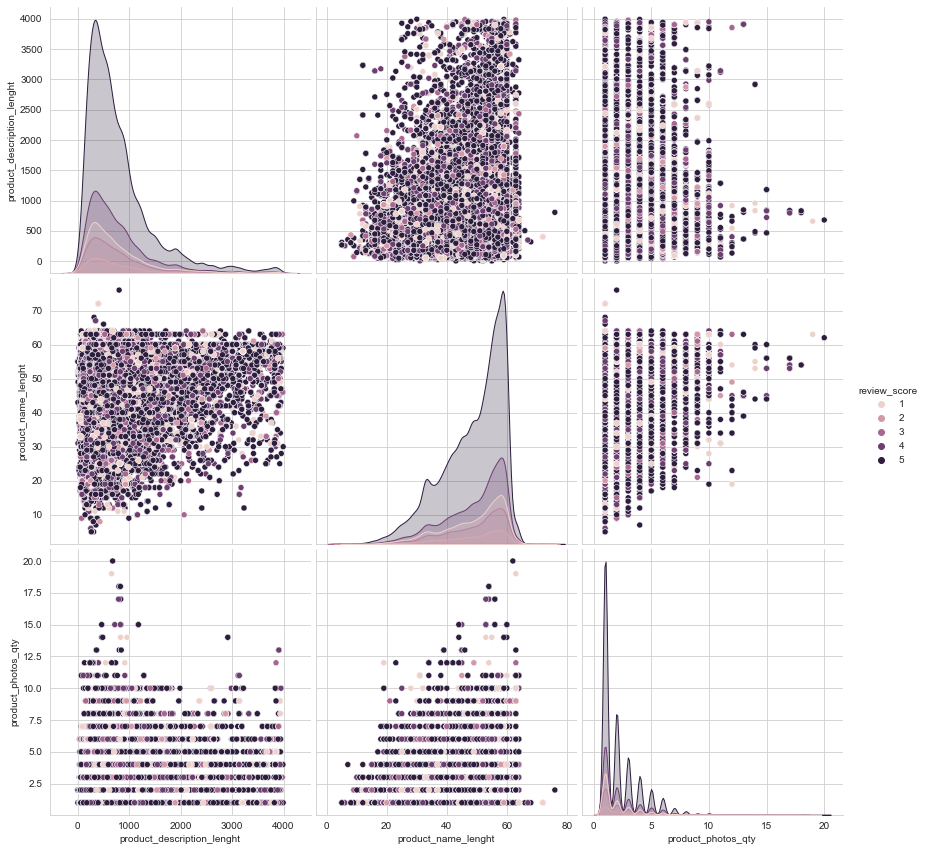

In [162]:
d = data[['product_description_lenght','product_name_lenght',
          'product_photos_qty','review_score']]
sns.set_style("whitegrid");
sns.pairplot(d, hue="review_score", height=4);
plt.show()

* Data is severly immbalaced, so scatter plot is able to separate the classes based on the selected feature.
* Point in the range (0-1500) product_description_length and product_name_length in range(30-60) have high frequency of 5 rated review.

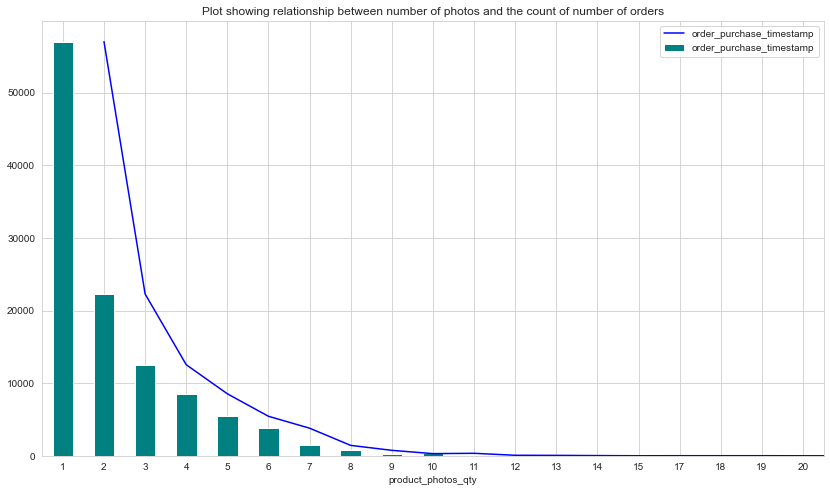

In [163]:
#plot showing relationship among number of photos and the count of number of orders
d = data.groupby(data['product_photos_qty'].astype(int))['order_purchase_timestamp'].count()
d.plot(kind='bar',figsize=(14,8),color='teal')
d.plot(kind='line',figsize=(14,8),color='b')
plt.legend()
plt.title('Plot showing relationship between number of photos and the count of number of orders')
plt.show()

* Density plots for the product name length shows that density around is very high around (40-60) range.
* Number of orders w.r.t number of photos qty starts to decrease with increasing in number of photos which is not very obvious. This may be because of other feature like product_description length or name length.

In [164]:
#taking only those points which was shown in the scatter plot
d = data[(data['product_name_lenght'] > 40) & (data['product_name_lenght'] < 60) & (data['product_description_lenght'] < 1500)]

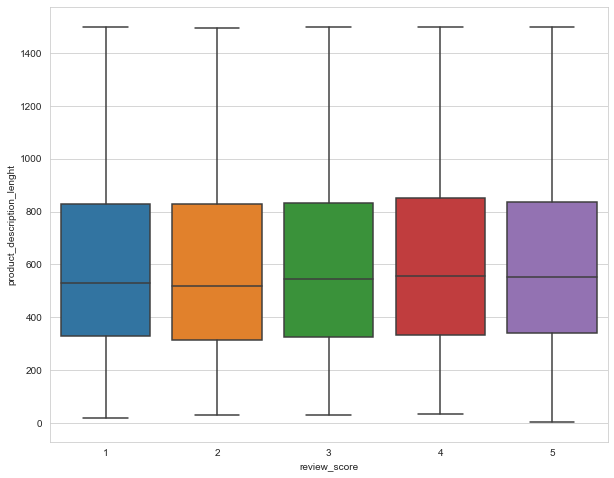

In [165]:
plt.figure(figsize=(10,8))
sns.boxplot(x='review_score',y='product_description_lenght', data=d)
plt.show()

* Even after taking the most favourable data, there is still no significant difference.

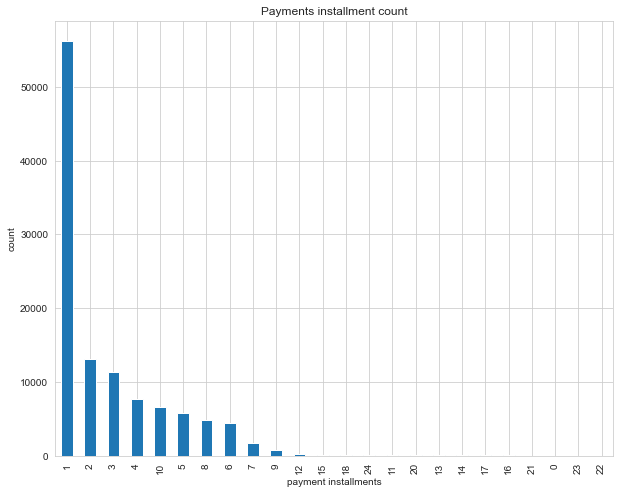

In [166]:
#payments installments
plt.figure(figsize=(10,8))
data.payment_installments.value_counts().plot(kind = 'bar',figsize=(10,8))
plt.title('Payments installment count')
plt.xlabel('payment installments')
plt.ylabel('count')
plt.show()

**Feature Engineering - DateTime variables**

In [167]:
#converting the timestamp format data to date data as we need just the date and not the exact time
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp']).dt.date
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date']).dt.date
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date']).dt.date
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date']).dt.date
data['review_creation_date'] = pd.to_datetime(data['review_creation_date']).dt.date
data['review_answer_timestamp'] = pd.to_datetime(data['review_answer_timestamp']).dt.date

In [168]:
type(data['order_delivered_customer_date'][0])

datetime.date

In [169]:
start = data['order_purchase_timestamp']
end1 = data['order_estimated_delivery_date']
end2 = data['order_delivered_customer_date']
ship = data['shipping_limit_date']
review_start = data['review_creation_date']
review_end = data['review_answer_timestamp']

In [170]:
#subtracting the order_purchase_time to rest time based feature 
data['delivery_days'] = end2 -  start
data['estimated_days'] = end1 - start
data['ships_in'] = ship - start

In [171]:
#subtracting the review_creation_date from review_answer_timestamp to find review_time 
data['review_time'] = review_end - review_start

In [172]:
#replacing the time stamp notation and converting type to int
data['delivery_days'] = pd.to_numeric(data['delivery_days'].dt.days, downcast='integer')
data['estimated_days'] = pd.to_numeric(data['estimated_days'].dt.days, downcast='integer')
data['ships_in'] = pd.to_numeric(data['ships_in'].dt.days, downcast='integer')
data['review_time'] = pd.to_numeric(data['review_time'].dt.days, downcast='integer')

In [173]:
data['arrival_time'] = (data['estimated_days'] - data['delivery_days']).apply(lambda x: 'Early/OnTime' if x > 0 else 'Late')

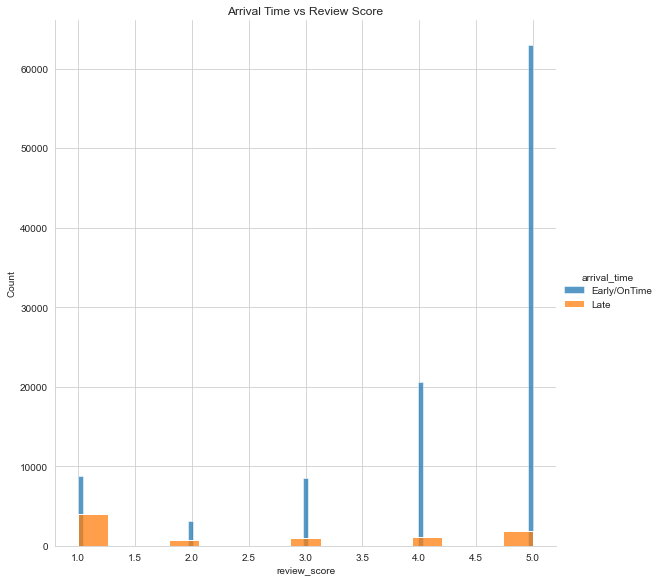

In [174]:
sns.FacetGrid(data, hue='arrival_time', height=8).map(sns.histplot, 'review_score').add_legend()
plt.title('Arrival Time vs Review Score')
plt.show()

In [175]:
data.arrival_time.value_counts()

Early/OnTime    103984
Late              8660
Name: arrival_time, dtype: int64

* From the above plot the cutomers are more likely to give an 4-5 rating if the product either arrives early or arrive on time.
* As delivery time impacts a lot on the customer ratings, we proceed further analysis on the delivery time.

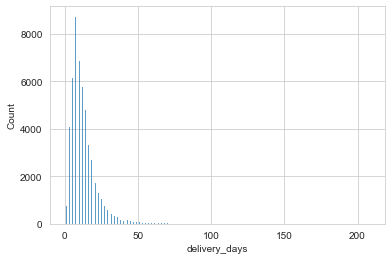

In [176]:
sns.histplot(data['delivery_days'])
plt.show()

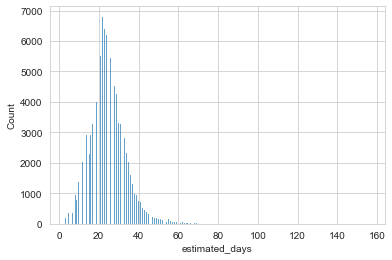

In [177]:
sns.histplot(data['estimated_days'])
plt.show()

* Based on the plot, we drop the outliers for delivery_days, estimated_days and ships_in (values > 60 days)

In [178]:
inx = data[(data['delivery_days'] > 60) | (data['estimated_days'] > 60) | (data['ships_in'] > 60)].index
print(inx.shape)

(605,)


In [179]:
data.drop(inx,inplace=True)

* Grouping delivery times into feedback classes

In [180]:
delivery_feedbacks = []
estimated_del_feedbacks = []
shipping_feedback = []
del_days = data.delivery_days.values.tolist()
est_days = data.estimated_days.values.tolist()
ship_days = data.ships_in.values.tolist()

In [181]:
#actural delivery days
for i in del_days:
    if i in range(0,16):
        delivery_feedbacks.append('Fast')
    elif i in range(16,25):
        delivery_feedbacks.append('Neutral')
    elif i in range(25,61):
        delivery_feedbacks.append('Slow')

#estimated delivery days
for i in est_days:
    if i in range(0,16):
        estimated_del_feedbacks.append('Fast')
    elif i in range(16,25):
        estimated_del_feedbacks.append('Neutral')
    elif i in range(25,61):
        estimated_del_feedbacks.append('Slow')

#estimated shipping days
for i in ship_days:
    if i in range(0,8):
        shipping_feedback.append('Fast')
    elif i in range(8,16):
        shipping_feedback.append('Neutral')
    elif i in range(16,61):
        shipping_feedback.append('Slow')

In [182]:
#Adding list values into the dataframe as feature
data['delivery_impression'] = delivery_feedbacks
data['estimated_del_impression'] = estimated_del_feedbacks
data['ship_impression'] = shipping_feedback

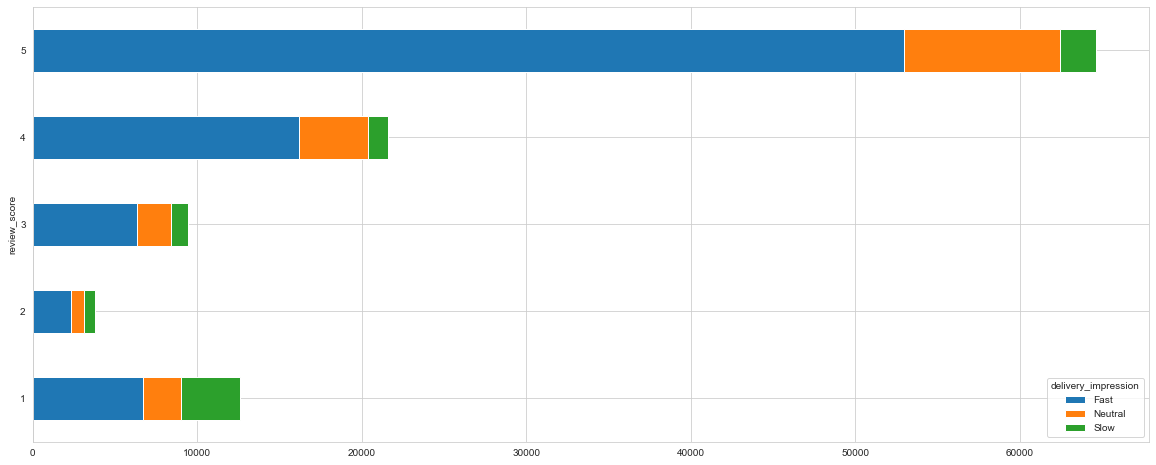

In [183]:
#Delivery Days histogram with review rating as hue
df_plot = data.groupby(['delivery_impression', 'review_score']).size().reset_index().pivot(columns='delivery_impression', index='review_score', values=0)
df_plot.plot(kind='barh',stacked=True,figsize=(20,8))
plt.show()

* The Histogram plot clearly shows the importance of fast delivery on the customer review score

In [184]:
data.delivery_impression.value_counts()

Fast       84500
Neutral    18873
Slow        8666
Name: delivery_impression, dtype: int64

In [185]:
data.estimated_del_impression.value_counts()

Slow       51708
Neutral    44222
Fast       16109
Name: estimated_del_impression, dtype: int64

In [186]:
data.ship_impression.value_counts()

Fast       84205
Neutral    25629
Slow        2205
Name: ship_impression, dtype: int64

* As per the statistics, majority of the orders are within Fast and Neutral categories
* However, it is interesting to note that the catogories within the estimated_del_impression shows a safer estimate from the company regarding the shipment arrival

**Feature Engineering for Customer Unique ID & Seller ID**

In [187]:
from collections import Counter
#finding all those customers who have made multiple product purchases
order_counts = [k for k,v in Counter(data.customer_unique_id).items() if v > 1]
existing_customer = []
for i in data.customer_unique_id.values:
    if i in order_counts:
        existing_customer.append(1)
    else:
        existing_customer.append(0)
len(existing_customer)

112039

Seller_ID -

In [188]:
print('Number of orders from exisiting customer are: ',existing_customer.count(1))

Number of orders from exisiting customer are:  35080


In [189]:
#seller popularity based on number of orders for each seller
seller_popularity = []
seller = data.seller_id.value_counts().to_dict()
for i in data.seller_id.values:
    seller_popularity.append(seller[i])
data['seller_popularity'] = seller_popularity
data.shape

(112039, 45)

* As in most of the cases customer and seller zip_code do not match, we drop the feature as it will increase dimenssion by 34000.

In [190]:
#dropping all id based features
data.drop(['customer_unique_id','seller_id','product_id','zipCode_seller','zipCode_customer'],axis=1,inplace=True)

In [191]:
#adding exisitng customer and seller_ID feature
data['existing_customer'] = existing_customer
data.shape

(112039, 41)

* Dropping the datetime features as it is not required anymore

In [192]:
data.drop(['order_purchase_timestamp', 'order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date',
           'review_creation_date','review_answer_timestamp' ],axis=1,inplace=True)

In [193]:
data.columns

Index(['review_score', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_city',
       'customer_state', 'geolocation_lat_x', 'geolocation_lng_x',
       'order_item_id', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_city', 'seller_state', 'product_category_name',
       'geolocation_lat_y', 'geolocation_lng_y', 'delivery_days',
       'estimated_days', 'ships_in', 'review_time', 'arrival_time',
       'delivery_impression', 'estimated_del_impression', 'ship_impression',
       'seller_popularity', 'existing_customer'],
      dtype='object')

**Customer and Seller Location - Feature Engineering**

In [194]:
#!pip install geopy

In [195]:
import gmaps
import geopy.distance

In [196]:
customer_loc = data[['geolocation_lat_x', 'geolocation_lng_x']]
seller_loc = data[['geolocation_lat_y', 'geolocation_lng_y']]

In [197]:
customer_loc = customer_loc.values.tolist()
seller_loc = seller_loc.values.tolist()

In [198]:
tup_customer= [tuple(x) for x in customer_loc]
tup_seller = [tuple(x) for x in seller_loc]

In [199]:
zip_object = list(zip(tup_customer,tup_seller))

* Calculate Distance in Kilometers

In [200]:
distance = []
for i,j in zip_object:
    distance.append(geopy.distance.distance(i, j).km)

In [201]:
data['distance'] = np.round(distance,2)

* Dropping Latitudes and Longitudes from the Data

In [202]:
data.drop(['geolocation_lat_x', 'geolocation_lng_x',
        'geolocation_lat_y', 'geolocation_lng_y'],axis=1,inplace=True)

**Review Score - Sorting into classes**

* if score > 3, set score = 1 (Good)
* if score < 3, set score = 0 (Bad)

In [203]:
data.loc[data['review_score'] < 3 ,'Score'] = 0
data.loc[data['review_score'] > 3,'Score'] = 1
#removing neutral reviews
data.drop(data[data['review_score'] == 3].index,inplace=True)
data.drop('review_score',axis=1,inplace=True)

In [204]:
data.head()

,payment_sequential,payment_type,payment_installments,payment_value,customer_city,customer_state,order_item_id,price,freight_value,product_name_lenght,...,ships_in,review_time,arrival_time,delivery_impression,estimated_del_impression,ship_impression,seller_popularity,existing_customer,distance,Score
0,1,credit_card,1,18.12,sao paulo,SP,1,29.99,8.72,40.0,...,4,1,Early/OnTime,Fast,Neutral,Fast,58,1,18.05,1.0
1,3,voucher,1,2.00,sao paulo,SP,1,29.99,8.72,40.0,...,4,1,Early/OnTime,Fast,Neutral,Fast,58,1,18.05,1.0
2,2,voucher,1,18.59,sao paulo,SP,1,29.99,8.72,40.0,...,4,1,Early/OnTime,Fast,Neutral,Fast,58,1,18.05,1.0
3,1,boleto,1,141.46,barreiras,BA,1,118.70,22.76,29.0,...,6,0,Early/OnTime,Fast,Neutral,Fast,125,0,852.26,1.0
4,1,credit_card,3,179.12,vianopolis,GO,1,159.90,19.22,46.0,...,5,4,Early/OnTime,Fast,Slow,Fast,1169,0,511.82,1.0


In [205]:
print(data.shape)
print('Final set of features are : ',data.columns)

(102617, 31)
Final set of features are :  Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_city', 'customer_state', 'order_item_id',
       'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_city', 'seller_state', 'product_category_name', 'delivery_days',
       'estimated_days', 'ships_in', 'review_time', 'arrival_time',
       'delivery_impression', 'estimated_del_impression', 'ship_impression',
       'seller_popularity', 'existing_customer', 'distance', 'Score'],
      dtype='object')


**Revisiting State based data**

In [206]:
data['customer_state'].value_counts()

SP    43748
RJ    13184
MG    12017
RS     5754
PR     5309
SC     3740
BA     3373
GO     2058
ES     2035
DF     2016
PE     1631
CE     1301
MT      930
PA      924
MS      773
MA      703
PB      539
RN      494
PI      484
AL      399
SE      347
TO      291
RO      236
AM      153
AC       79
AP       67
RR       32
Name: customer_state, dtype: int64

Considering % contribution from top ten states

In [207]:
(pd.DataFrame(data['customer_state'].value_counts()[0:10])/102617*100).sum()

customer_state    90.856291
dtype: float64

Dropping states other than top ten

In [208]:
data = data[~data.customer_state.str.contains('PE|CE')]
data = data[~data.customer_state.str.contains('MT|PA')]
data = data[~data.customer_state.str.contains('MS|MA')]
data = data[~data.customer_state.str.contains('PB|RN')]
data = data[~data.customer_state.str.contains('PI|AL')]
data = data[~data.customer_state.str.contains('SE|TO')]
data = data[~data.customer_state.str.contains('RO|AM')]
data = data[~data.customer_state.str.contains('AC|AP')]
data = data[~data.customer_state.str.contains('RR')]
data.shape

(93234, 31)

In [209]:
data['customer_state'].value_counts()

SP    43748
RJ    13184
MG    12017
RS     5754
PR     5309
SC     3740
BA     3373
GO     2058
ES     2035
DF     2016
Name: customer_state, dtype: int64

Considering % contribution from top ten states (seller)

In [210]:
(pd.DataFrame(data['seller_state'].value_counts()[0:10])/93234*100).sum()

seller_state    99.061501
dtype: float64

Dropping states other than top ten

In [211]:
data = data[~data.seller_state.str.contains('ES|MA')]
data = data[~data.seller_state.str.contains('MT|MS')]
data = data[~data.seller_state.str.contains('CE|RN')]
data = data[~data.seller_state.str.contains('PB|RO')]
data = data[~data.seller_state.str.contains('PI|PA')]
data = data[~data.seller_state.str.contains('SE|AM')]
data.shape

(92359, 31)

In [212]:
data['seller_state'].value_counts()

SP    66377
PR     7445
MG     7206
RJ     4005
SC     3558
RS     1846
DF      693
BA      485
GO      406
PE      338
Name: seller_state, dtype: int64

**Visiting Seller and Customer City**

In [213]:
(pd.DataFrame(data['customer_city'].value_counts()[0:620])/92359*100).sum()

customer_city    90.142812
dtype: float64

It takes 620 cities to make 90 % of the purchase records. We can drop this due to high categories

In [214]:
(pd.DataFrame(data['seller_city'].value_counts()[0:110])/92359*100).sum()

seller_city    89.299364
dtype: float64

It takes 42 cities to make 90 % of the seller records. We can drop this due to high categories

In [215]:
(pd.DataFrame(data['product_category_name'].value_counts()[0:23])/92359*100).sum()

product_category_name    90.911552
dtype: float64

It takes 23 cities to make 90 % of the product types, with 71 unique entries. We can drop this due to high categories

In [216]:
data.drop(['seller_city','customer_city','product_category_name'],axis=1,inplace=True)

In [217]:
data['freight_ratio'] = data['freight_value']/(data['price'] + data['freight_value'])

In [218]:
data['size'] = (data['product_length_cm']*data['product_height_cm'])*data['product_width_cm']

In [219]:
data.drop(['product_length_cm','product_height_cm','product_width_cm'],axis=1,inplace=True)

**Ranking Ordinal Categorical Variables**

* arrival_time
* delivery_impression
* estimated_del_impression
* ship_impression
* payment_installments

In [220]:
data.arrival_time = data.arrival_time.apply(lambda x: '1' if x =='Early/OnTime' else '0')

In [221]:
def condition(x):
    if x == 'Fast':
        return 2
    elif x == 'Neutral':
        return 1
    else:
        return 0

In [222]:
data.delivery_impression = data.delivery_impression.apply(condition)

In [223]:
data.estimated_del_impression = data.estimated_del_impression.apply(condition)

In [224]:
data.ship_impression = data.ship_impression.apply(condition)

Payment Installment (Fast if within 6 months, neutral if between 6 to 12 months, late if otherwise)

In [225]:
def condition_2(x):
    if x <= 6:
        return 2
    elif x >6 & x <= 12:
        return 1
    else:
        return 0

In [226]:
data.payment_installments = data.payment_installments.apply(condition_2)

In [227]:
data.payment_installments.value_counts()

2    81105
1    11254
Name: payment_installments, dtype: int64

**Revisiting payment_sequential data**

In [228]:
data.payment_sequential.value_counts()[0:5]/92359*100

1    95.708052
2     2.782620
3     0.571682
4     0.276097
5     0.169989
Name: payment_sequential, dtype: float64

Since 95% of the data is covered under payment sequence = 1, we drop this column 

In [229]:
data.drop(['payment_sequential'],axis=1,inplace=True)

Creating categories for review_time

In [230]:
data.review_time.describe()

count    92359.000000
mean         2.586960
std         10.146049
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        518.000000
Name: review_time, dtype: float64

In [231]:
data.review_time = data.review_time.apply(lambda x: '1' if x <= 3 else '0')

In [232]:
print(data.columns)
data.shape

Index(['payment_type', 'payment_installments', 'payment_value',
       'customer_state', 'order_item_id', 'price', 'freight_value',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'seller_state',
       'delivery_days', 'estimated_days', 'ships_in', 'review_time',
       'arrival_time', 'delivery_impression', 'estimated_del_impression',
       'ship_impression', 'seller_popularity', 'existing_customer', 'distance',
       'Score', 'freight_ratio', 'size'],
      dtype='object')


(92359, 26)

In [233]:
data.to_csv('preprocessed_data.csv',index=False)

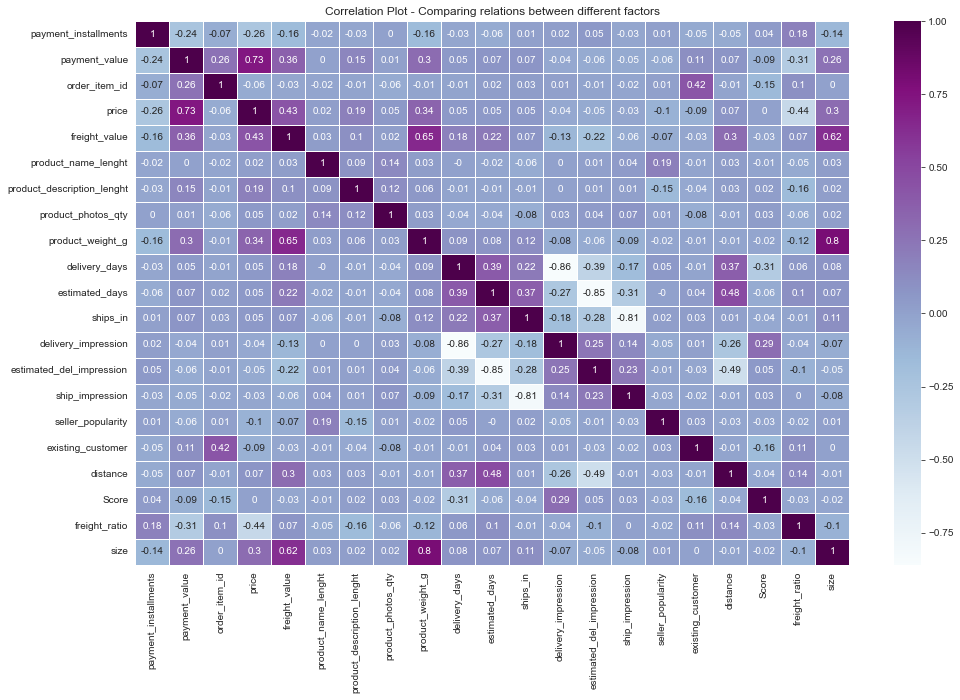

In [234]:
#Correlation Plot
%matplotlib inline
plt.figure(figsize=(16,10))
sns.heatmap(data.corr().round(2), annot = True, linewidths=0.5, linecolor="white", cmap='BuPu')
plt.title('Correlation Plot - Comparing relations between different factors')
plt.show()